In [1]:
from astropy.timeseries import LombScargle
import gPhoton.dbasetools as dt
import gPhoton.galextools as gt
import gPhoton.MCUtils as mc
from gPhoton.gphoton_utils import read_lc
from gPhoton import gAperture
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
from scipy.signal import savgol_filter
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import make_lightcurve, listdir_contains
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Restore the output directory.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the location of the products made from the "generate_products" notebook.
%store -r data_directory
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the location of the output products.
#data_directory = "./raw_files/"

In [4]:
# Restore the skypos parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the sky position to use.
%store -r skypos
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the sky position in degrees.
#skypos = (24.76279, -17.94948)

In [5]:
# Locate the photon files.
photon_files = {'NUV':listdir_contains(data_directory,'nd.csv'),
                'FUV':listdir_contains(data_directory,'fd.csv')}

In [6]:
# Since this flare has such a large count rate, we can make a 5-second light curve to explore it's shape in detail.
# Flare #8 is in Visit #5 (index 4 in our array of .csv files.) Note that if you already have
# created the 5-second light curve files previously this will not overwrite them.
lc_nuv = make_lightcurve(photon_files['NUV'][4], 'NUV', stepsz=5., skypos=skypos, quiet=False, makefile=False)
lc_fuv = make_lightcurve(photon_files['FUV'][4], 'FUV', stepsz=5., skypos=skypos, fixed_t0=lc_nuv['t0'].min(),
                             quiet=True, makefile=False)

/Users/fleming/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whi

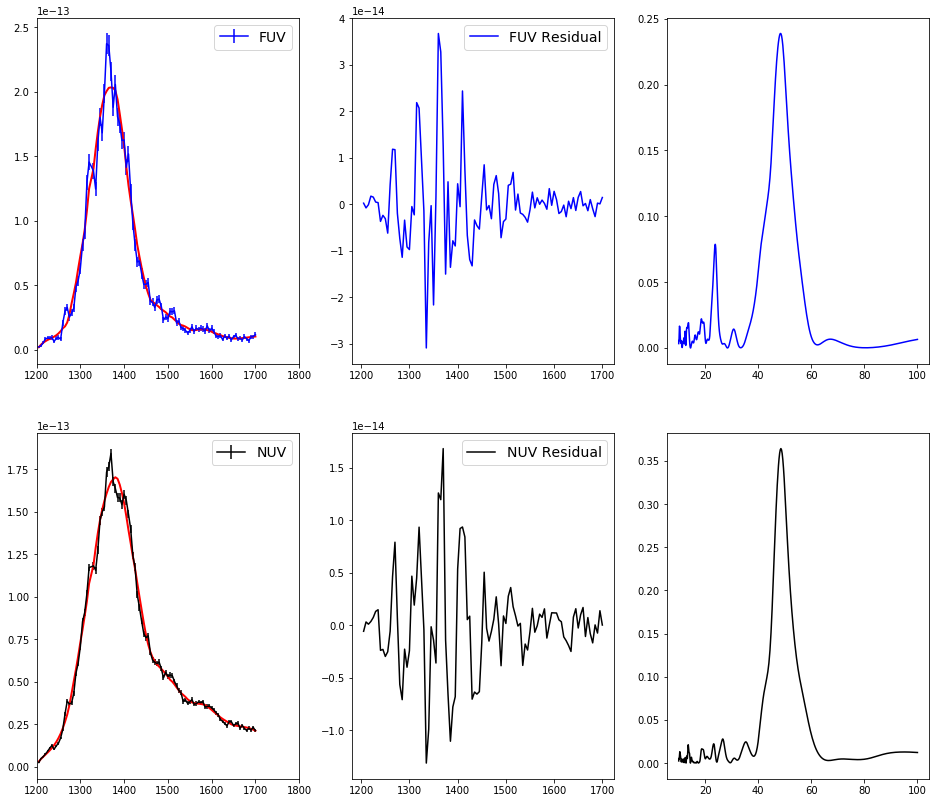

In [7]:
# There is visual evidence of in-flare variability, let's remove a simple flare shape and make a quick periodorgram
# of the residuals.
times_fuv = np.asarray(lc_fuv["t0"]-min(lc_fuv["t0"]))
times_nuv = np.asarray(lc_nuv["t0"]-min(lc_nuv["t0"]))
where_flare_fuv = np.where((times_fuv > 1200.) & (np.isfinite(lc_fuv['flux_apcorrected'])))[0]
where_flare_nuv = np.where((times_nuv > 1200.) * (np.isfinite(lc_nuv['flux_apcorrected'])))[0]
flare_times_fuv = times_fuv[where_flare_fuv]
flare_fluxes_fuv = np.asarray(lc_fuv["flux_apcorrected"])[where_flare_fuv]
flare_flux_errs_fuv = np.asarray(lc_fuv["flux_err"])[where_flare_fuv]
flare_times_nuv = times_nuv[where_flare_nuv]
flare_fluxes_nuv = np.asarray(lc_nuv["flux_apcorrected"])[where_flare_nuv]
flare_flux_errs_nuv = np.asarray(lc_nuv["flux_err"])[where_flare_nuv]

# Fit a simple shape for the flare, let's use a Savitzky-Golay filter.
fluxfitted_fuv = savgol_filter(flare_fluxes_fuv, 21, 3)
fluxfitted_nuv = savgol_filter(flare_fluxes_nuv, 21, 3)
                           
# Let's do a periodagram to check for any strong periodic signals.
lombscarg_fuv = LombScargle(flare_times_fuv, flare_fluxes_fuv-fluxfitted_fuv)
frequency_fuv, power_fuv = lombscarg_fuv.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_nuv = LombScargle(flare_times_nuv, flare_fluxes_nuv-fluxfitted_nuv)
frequency_nuv, power_nuv = lombscarg_nuv.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)

# Let's make a plot of the flare region of the light curve we are looking at (left column).
# We'll also show the quick periodgrams we made (right column).
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.errorbar(flare_times_fuv, flare_fluxes_fuv, yerr=flare_flux_errs_fuv,
             fmt='-b', label="FUV")
ax1.plot(flare_times_fuv, fluxfitted_fuv, '-r', linewidth=2)
ax2.plot(flare_times_fuv, flare_fluxes_fuv - fluxfitted_fuv, '-b', label="FUV Residual")
ax3.plot(1./frequency_fuv, power_fuv, '-b')
ax4.errorbar(flare_times_nuv, flare_fluxes_nuv, yerr=flare_flux_errs_nuv,
             fmt='-k', label="NUV")
ax4.plot(flare_times_nuv, fluxfitted_nuv, '-r', linewidth=2)
ax5.plot(flare_times_nuv, flare_fluxes_nuv - fluxfitted_nuv, '-k', label="NUV Residual")
ax6.plot(1./frequency_nuv, power_nuv, '-k')
# Set axis ranges appropriately.
ax1.set_xlim(1200., 1800.)
ax4.set_xlim(1200., 1800.)
ax1.legend()
ax2.legend()
ax4.legend()
ax5.legend()
plt.show()

In [8]:
# What is the peak frequency and power?
# Convert to numpy arrays to make use of the where() function.
frequency_fuv = np.asarray(frequency_fuv)
frequency_nuv = np.asarray(frequency_nuv)
power_fuv = np.asarray(power_fuv)
power_nuv = np.asarray(power_nuv)

print("FUV Max Period = " + str(1./frequency_fuv[np.argmax(power_fuv)]) + " sec" +
         " with FAP = " +
      str(lombscarg_fuv.false_alarm_probability(power_fuv.max())))
print("NUV Max Period = " + str(1./frequency_nuv[np.argmax(power_nuv)]) + " sec" +
         " with FAP = " +
     str(lombscarg_nuv.false_alarm_probability(power_nuv.max())))

FUV Max Period = 48.292682926829265 sec with FAP = 0.00203918256199538
NUV Max Period = 48.52941176470588 sec with FAP = 4.862508154469334e-07


Both bands show VERY strong signals with identical periods.  A more careful analysis is in order.  But before then, let's check other parts of the light curve, and other stars in the same field-of-view, to see if they have similarly strong signals anywhere.

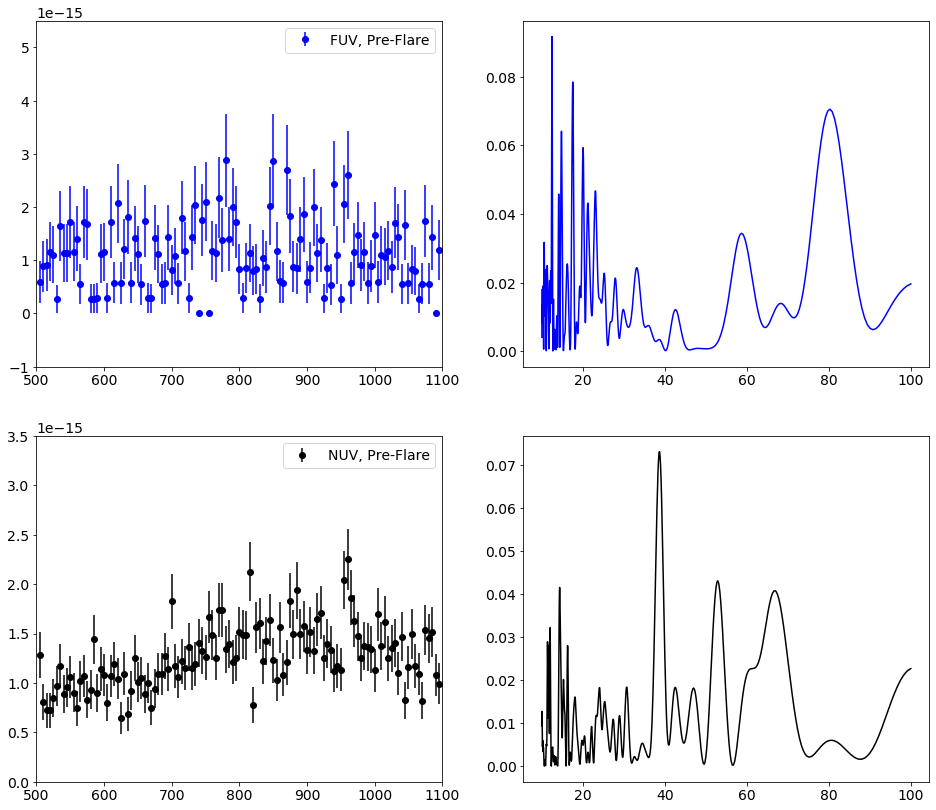

In [9]:
# We see evidence of in-flare pulsations, but is there any evidence of out-of-flare pulsations?
# Let's zoom-in on the long stretch of time before the large flare begins.
where_preflare_fuv = np.where((times_fuv > 500.) & (times_fuv < 1100.))[0]
where_preflare_nuv = np.where((times_nuv > 500.) & (times_nuv < 1100.))[0]
preflare_times_fuv = times_fuv[where_preflare_fuv]
preflare_fluxes_fuv = np.asarray(lc_fuv["flux_apcorrected"])[where_preflare_fuv]
preflare_flux_errs_fuv = np.asarray(lc_fuv["flux_err"])[where_preflare_fuv]
preflare_times_nuv = times_nuv[where_preflare_nuv]
preflare_fluxes_nuv = np.asarray(lc_nuv["flux_apcorrected"])[where_preflare_nuv]
preflare_flux_errs_nuv = np.asarray(lc_nuv["flux_err"])[where_preflare_nuv]

# Let's do a periodagram to check for any strong periodic signals.
lombscarg_fuv = LombScargle(preflare_times_fuv, preflare_fluxes_fuv)
frequency_fuv, power_fuv = lombscarg_fuv.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_nuv = LombScargle(preflare_times_nuv, preflare_fluxes_nuv)
frequency_nuv, power_nuv = lombscarg_nuv.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)

# Let's make a plot of the pre-flare region of the light curve we are looking at (left column).
# We'll also show the quick periodgrams we made (right column).
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.errorbar(preflare_times_fuv, preflare_fluxes_fuv, yerr=preflare_flux_errs_fuv,
             fmt='bo', label="FUV, Pre-Flare")
ax3.errorbar(preflare_times_nuv, preflare_fluxes_nuv, yerr=preflare_flux_errs_nuv,
             fmt='ko', label="NUV, Pre-Flare")
ax2.plot(1./frequency_fuv, power_fuv, '-b')
ax4.plot(1./frequency_nuv, power_nuv, '-k')
# Set axis ranges appropriately.
ax1.set_xlim(500., 1100.)
ax3.set_xlim(500., 1100.)
ax1.set_ylim(-1E-15, 5.5E-15)
ax3.set_ylim(0, 3.5E-15)
ax1.legend()
ax3.legend()
plt.show()

In [10]:
# What is the peak frequency and power?
# Convert to numpy arrays to make use of the where() function.
frequency_fuv = np.asarray(frequency_fuv)
frequency_nuv = np.asarray(frequency_nuv)
power_fuv = np.asarray(power_fuv)
power_nuv = np.asarray(power_nuv)

print("FUV Max Period = " + str(1./frequency_fuv[np.argmax(power_fuv)]) + " sec" +
         " with FAP = " +
      str(lombscarg_fuv.false_alarm_probability(power_fuv.max())))
print("NUV Max Period = " + str(1./frequency_nuv[np.argmax(power_nuv)]) + " sec" +
         " with FAP = " +
     str(lombscarg_nuv.false_alarm_probability(power_nuv.max())))

FUV Max Period = 12.47357293868922 sec with FAP = 0.9401789504008122
NUV Max Period = 38.68852459016393 sec with FAP = 0.9996950954854695


The strongest peaks have >99% false alarm probability, so there's no periodic signal happening before the flare starts.

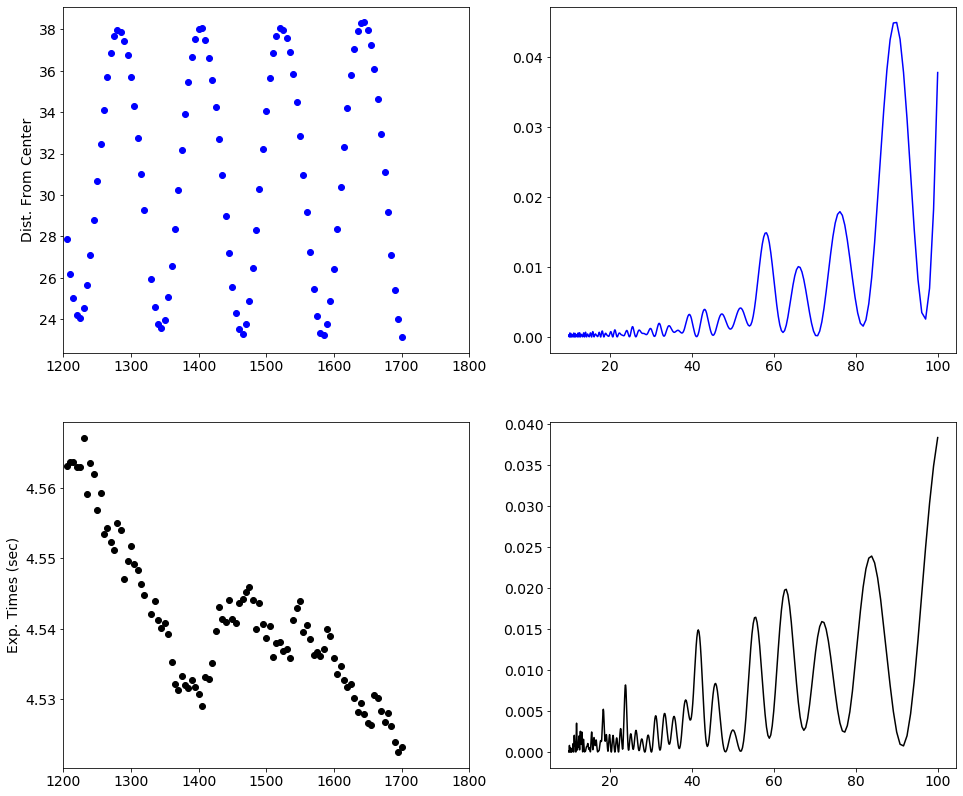

In [11]:
# One final test for GJ 65 itself: let's check what the periodgram of the spacecraft boresight looks like, to check
# if this signal might be induced as part of the dither pattern.  This can be tracked in gPhoton results with the
# 'detrad' parameter.  We will also make sure the variability is not correlated with the 
# effective exposure time within each time bin through the 'expt' parameter.
flare_detrads = np.asarray(lc_nuv["detrad"])[where_flare_nuv]
flare_expts = np.asarray(lc_nuv["expt"])[where_flare_nuv]

# Let's do a periodagram to check for any strong periodic signals.
lombscarg_nuv_detrad = LombScargle(flare_times_nuv, flare_detrads)
frequency_nuv_detrad, power_nuv_detrad = lombscarg_nuv_detrad.autopower(
    minimum_frequency=0.01, maximum_frequency=0.1, samples_per_peak=20)
lombscarg_nuv_expt = LombScargle(flare_times_nuv, flare_expts)
frequency_nuv_expt, power_nuv_expt = lombscarg_nuv_expt.autopower(
    minimum_frequency=0.01, maximum_frequency=0.1, samples_per_peak=20)

# Let's make a plot of these parameters over time (left column).
# We'll also show the quick periodgrams we made (right column).
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.plot(flare_times_nuv, flare_detrads, 'bo')
ax1.set_ylabel("Dist. From Center")
ax3.plot(flare_times_nuv, flare_expts, 'ko')
ax3.set_ylabel("Exp. Times (sec)")
ax2.plot(1./frequency_nuv_detrad, power_nuv_detrad, '-b')
ax4.plot(1./frequency_nuv_expt, power_nuv_expt, '-k')
# Set axis ranges appropriately.
ax1.set_xlim(1200., 1800.)
ax3.set_xlim(1200., 1800.)
plt.show()

In [12]:
# What is the peak frequency and power?
# Convert to numpy arrays to make use of the where() function.
frequency_nuv_detrad = np.asarray(frequency_nuv_detrad)
frequency_nuv_expt = np.asarray(frequency_nuv_expt)
power_nuv_detrad = np.asarray(power_nuv_detrad)
power_nuv_expt = np.asarray(power_nuv_expt)

print("NUV Detrad Max Period = " + str(1./frequency_nuv_detrad[np.argmax(power_nuv_detrad)]) +
      " sec with FAP = " +
      str(lombscarg_nuv_detrad.false_alarm_probability(power_nuv_detrad.max())))
print("NUV Exptime Max Period = " +
      str(1./frequency_nuv_expt[np.argmax(power_nuv_expt)]) + " sec" + " with FAP = " +
     str(lombscarg_nuv_expt.false_alarm_probability(power_nuv_expt.max())))

NUV Detrad Max Period = 90.0 sec with FAP = 1.0
NUV Exptime Max Period = 100.0 sec with FAP = 1.0


The strongest peaks have >99% false alarm probability, so there's no periodic signal within the frequency range we searched with any significance.

In [13]:
# Let's also check nearby stars to see if any of them show periodic pulsations during the same
# time period.  First let's look for nearby, known GALEX sources.
# This line will return all GALEX MCAT sources within 0.1 degrees of our coordinate, down to
# a magnitude of 21.
out = dt.get_mags('NUV', skypos[0], skypos[1], 0.1, 21.)
sources = np.asarray(dt.parse_unique_sources(out['ra'], out['dec']))
distances = np.asarray([mc.angularSeparation(skypos[0], skypos[1], x, y)*3600. for x,y in sources])
sort_indexes = np.argsort(distances)
sources = sources[sort_indexes]
distances = distances[sort_indexes]

In [14]:
# Let's identify the three closest sources that are not very close to GJ 65 (to avoid selecting
# the star itself.)  We'll look for the closest sources, but skip over sources that are
# very close to our target in case it is GJ 65 itself!
closest_sources = []
n_found = 0
for (ra, dec), dist in zip(sources, distances):
    # If within a GALEX spatial resolution element, ignore (probably GJ 65 itself).
    if dist > 6.:
        closest_sources.append({'ra':ra, 'dec':dec, 'dist':dist})
        n_found += 1
    if n_found == 3:
        break

In [15]:
for i,c in enumerate(closest_sources):
    # Create a 5-second light curve of each one. Note: each light curve can take many minutes
    # to create.
    print("Creating light curve for comparison star #" + str(i+1) + "...")
    lc_nuv = make_lightcurve(photon_files['NUV'][4], 'NUV', stepsz=5.,
                             lc_filename=data_directory + 'nearest{0:d}_5s.csv'.format(i+1),
                             skypos=[c['ra'], c['dec']], quiet=True, makefile=False)
    print(c)

Creating light curve for comparison star #1...
{'ra': 24.7810593371056, 'dec': -17.95474966916155, 'dist': 65.3803800424724}
Creating light curve for comparison star #2...
{'ra': 24.744296196045248, 'dec': -17.917551069089, 'dist': 131.24210810484757}
Creating light curve for comparison star #3...
{'ra': 24.79683015635855, 'dec': -17.96895129568545, 'dist': 136.02564805424237}


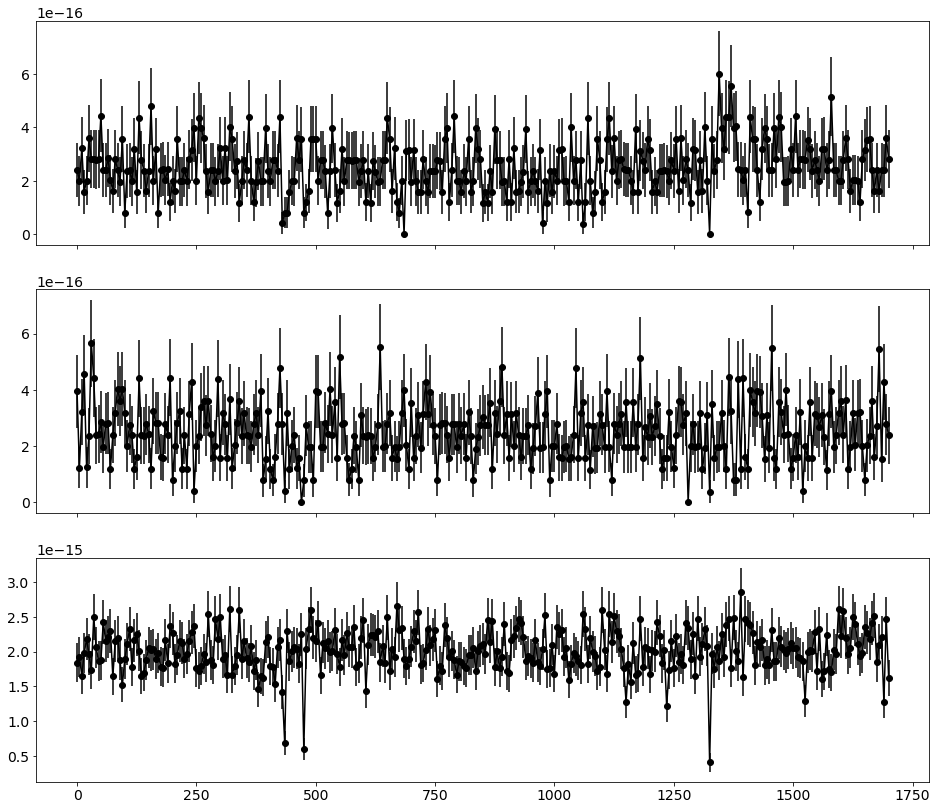

In [17]:
# Let's plot these light curves.
comp_lc_1 = read_lc(data_directory + "nearest1_5s.csv")
comp_lc_2 = read_lc(data_directory + "nearest2_5s.csv")
comp_lc_3 = read_lc(data_directory + "nearest3_5s.csv")
# Keep only those that have a decent amount of bin coverage.
where_keep1 = np.where(np.asarray(comp_lc_1['expt']) > 3.)[0]
where_keep2 = np.where(np.asarray(comp_lc_2['expt']) > 3.)[0]
where_keep3 = np.where(np.asarray(comp_lc_3['expt']) > 3.)[0]
times_1 = np.asarray(comp_lc_1['t0']-min(comp_lc_1['t0']))[where_keep1]
times_2 = np.asarray(comp_lc_2['t0']-min(comp_lc_2['t0']))[where_keep2]
times_3 = np.asarray(comp_lc_3['t0']-min(comp_lc_3['t0']))[where_keep3]
fluxes_1 = np.asarray(comp_lc_1['flux_apcorrected'])[where_keep1]
fluxes_2 = np.asarray(comp_lc_2['flux_apcorrected'])[where_keep2]
fluxes_3 = np.asarray(comp_lc_3['flux_apcorrected'])[where_keep3]
flux_err_1 = np.asarray(comp_lc_1['flux_err'])[where_keep1]
flux_err_2 = np.asarray(comp_lc_2['flux_err'])[where_keep2]
flux_err_3 = np.asarray(comp_lc_3['flux_err'])[where_keep3]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.errorbar(times_1, fluxes_1, yerr=flux_err_1, fmt='-ko')
ax2.errorbar(times_2, fluxes_2, yerr=flux_err_2, fmt='-ko')
ax3.errorbar(times_3, fluxes_3, yerr=flux_err_3, fmt='-ko')
plt.show()

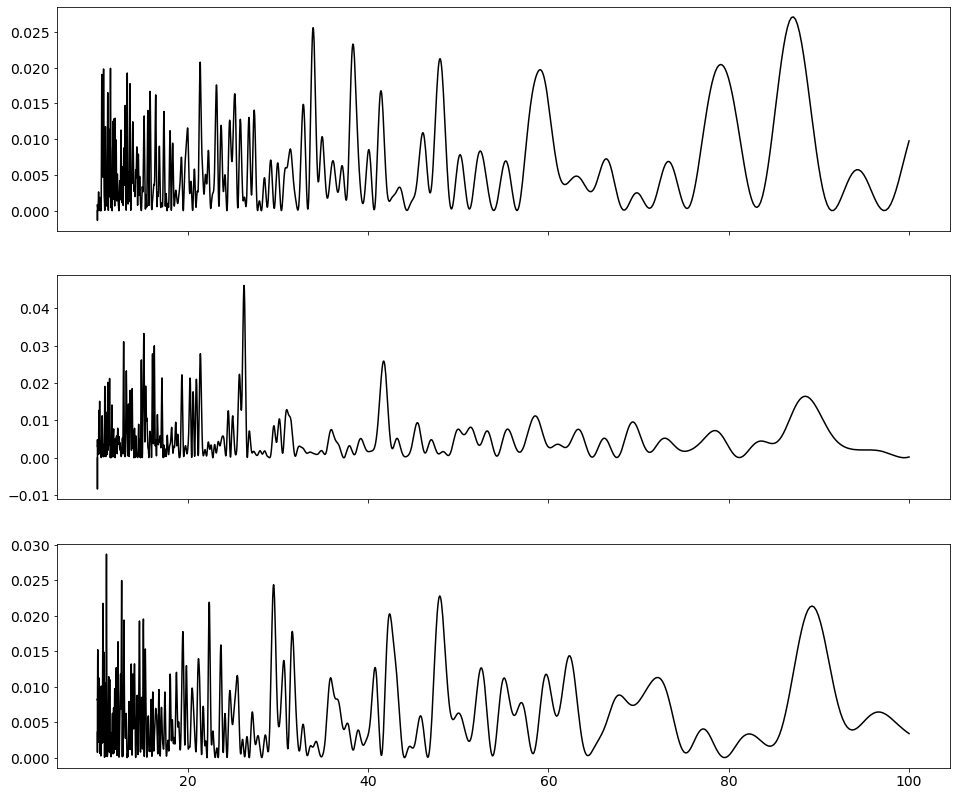

In [19]:
# Now let's check for any strong periodicity.
lombscarg_1 = LombScargle(times_1, fluxes_1)
frequency_1, power_1 = lombscarg_1.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_2 = LombScargle(times_2, fluxes_2)
frequency_2, power_2 = lombscarg_2.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_3 = LombScargle(times_3, fluxes_3)
frequency_3, power_3 = lombscarg_3.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.plot(1./frequency_1, power_1, '-k')
ax2.plot(1./frequency_2, power_2, '-k')
ax3.plot(1./frequency_3, power_3, '-k')
plt.show()

In [20]:
frequency_1 = np.asarray(frequency_1)
frequency_2 = np.asarray(frequency_2)
frequency_3 = np.asarray(frequency_3)
power_1 = np.asarray(power_1)
power_2 = np.asarray(power_2)
power_3 = np.asarray(power_3)

print("Comp. 1 Max Period = " + str(1./frequency_1[np.argmax(power_1)]) + " sec" +
         " with FAP = " +
      str(lombscarg_1.false_alarm_probability(power_1.max())))
print("Comp. 2 Max Period = " + str(1./frequency_2[np.argmax(power_2)]) + " sec" +
         " with FAP = " +
      str(lombscarg_2.false_alarm_probability(power_2.max())))
print("Comp. 3 Max Period = " + str(1./frequency_3[np.argmax(power_3)]) + " sec" +
         " with FAP = " +
      str(lombscarg_3.false_alarm_probability(power_3.max())))


Comp. 1 Max Period = 87.17948717948718 sec with FAP = 0.9999999889792632
Comp. 2 Max Period = 26.254826254826256 sec with FAP = 0.5779260405904102
Comp. 3 Max Period = 11.006798316607318 sec with FAP = 0.9999994077045082


No statistically significant peaks are detected.

In [21]:
# Now instead of finding the three closest stars, let's find the three closest stars that are
# within 1 magnitude of GJ 65's peak brightness during the flare. This will test if there is
# any systematic that only shows up under count rates comparable due to GJ 65 at peak brightness.
gj65_brightest = max(lc_nuv["flux_apcorrected"])
gj65_brightest_mag = gt.counts2mag(gj65_brightest / 2.06e-16, "NUV")
out = dt.get_mags('NUV', skypos[0], skypos[1], 0.6, gj65_brightest_mag + 1.)
sources = np.asarray(dt.parse_unique_sources(out['ra'], out['dec'], margin=6./3600.))
distances = np.asarray([mc.angularSeparation(skypos[0], skypos[1], x, y)*3600. for x,y in sources])
sort_indexes = np.argsort(distances)
sources = sources[sort_indexes]
distances = distances[sort_indexes]

In [22]:
# Get the closest similarly-bright stars, but ignore self-detections of GJ 65 in the MCAT.
closest_sources = []
n_found = 0
for (ra, dec), dist in zip(sources, distances):
    # If within a GALEX spatial resolution element, ignore (probably GJ 65 itself).
    if dist > 6.:
        closest_sources.append({'ra':ra, 'dec':dec, 'dist':dist})
        n_found += 1
    if n_found == 3:
        break

In [24]:
for i,c in enumerate(closest_sources):
    # Create a 5-second light curve of each one. Note: each light curve can take many minutes
    # to create.
    print("Creating light curve for comparison star #" + str(i+1) + "...")
    lc_nuv = make_lightcurve(photon_files['NUV'][4], 'NUV', stepsz=5.,
                             lc_filename=data_directory + 'brightest{0:d}_5s.csv'.format(i+1),
                             skypos=[c['ra'], c['dec']], quiet=True, makefile=False)
    print(c)

Creating light curve for comparison star #1...
{'ra': 24.79683015635855, 'dec': -17.96895129568545, 'dist': 136.02564805424237}
Creating light curve for comparison star #2...
{'ra': 24.834205525802098, 'dec': -17.99141403833535, 'dist': 287.39551362745823}
Creating light curve for comparison star #3...
{'ra': 24.68815857406225, 'dec': -17.90635015473045, 'dist': 299.0876745159542}


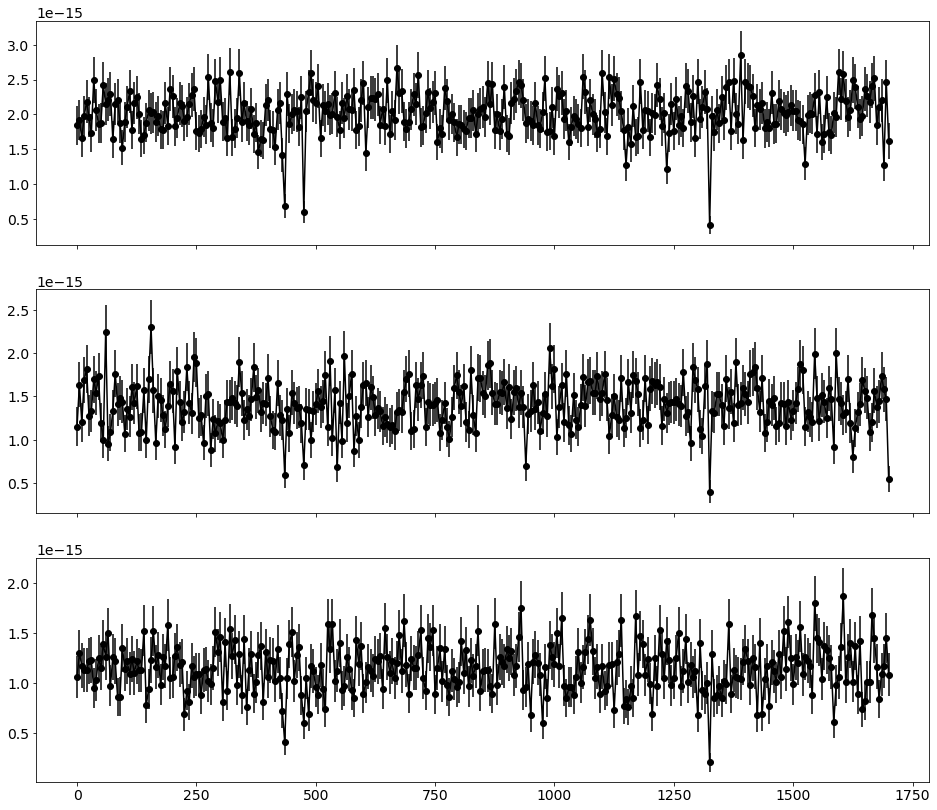

In [26]:
# Let's plot these light curves.
bright_lc_1 = read_lc(data_directory + "brightest1_5s.csv")
bright_lc_2 = read_lc(data_directory + "brightest2_5s.csv")
bright_lc_3 = read_lc(data_directory + "brightest3_5s.csv")
# Keep only those that have a decent amount of bin coverage.
where_keep1 = np.where(np.asarray(bright_lc_1['expt']) > 3.)[0]
where_keep2 = np.where(np.asarray(bright_lc_2['expt']) > 3.)[0]
where_keep3 = np.where(np.asarray(bright_lc_3['expt']) > 3.)[0]
times_1 = np.asarray(bright_lc_1['t0']-min(bright_lc_1['t0']))[where_keep1]
times_2 = np.asarray(bright_lc_2['t0']-min(bright_lc_2['t0']))[where_keep2]
times_3 = np.asarray(bright_lc_3['t0']-min(bright_lc_3['t0']))[where_keep3]
fluxes_1 = np.asarray(bright_lc_1['flux_apcorrected'])[where_keep1]
fluxes_2 = np.asarray(bright_lc_2['flux_apcorrected'])[where_keep2]
fluxes_3 = np.asarray(bright_lc_3['flux_apcorrected'])[where_keep3]
flux_err_1 = np.asarray(bright_lc_1['flux_err'])[where_keep1]
flux_err_2 = np.asarray(bright_lc_2['flux_err'])[where_keep2]
flux_err_3 = np.asarray(bright_lc_3['flux_err'])[where_keep3]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.errorbar(times_1, fluxes_1, yerr=flux_err_1, fmt='-ko')
ax2.errorbar(times_2, fluxes_2, yerr=flux_err_2, fmt='-ko')
ax3.errorbar(times_3, fluxes_3, yerr=flux_err_3, fmt='-ko')
plt.show()

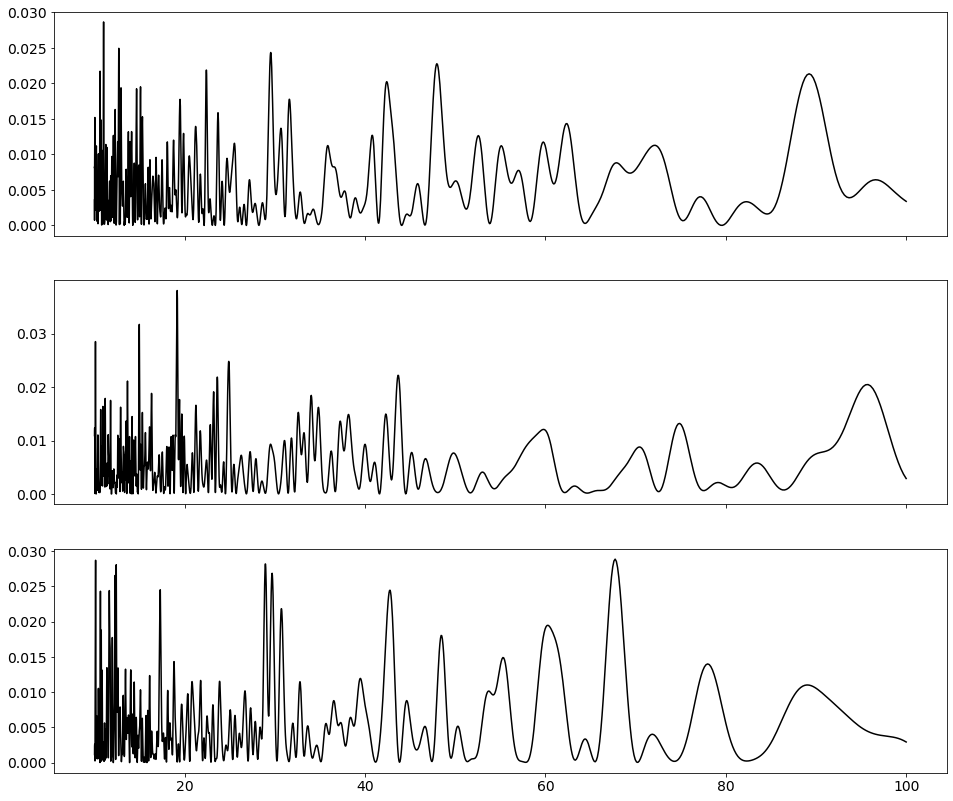

In [28]:
# Now let's check for any strong periodicity.
lombscarg_1 = LombScargle(times_1, fluxes_1)
frequency_1, power_1 = lombscarg_1.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_2 = LombScargle(times_2, fluxes_2)
frequency_2, power_2 = lombscarg_2.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
lombscarg_3 = LombScargle(times_3, fluxes_3)
frequency_3, power_3 = lombscarg_3.autopower(minimum_frequency=0.01, maximum_frequency=0.1,
                                                   samples_per_peak=20)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,14))
matplotlib.rcParams.update({'font.size': 14})
ax1.plot(1./frequency_1, power_1, '-k')
ax2.plot(1./frequency_2, power_2, '-k')
ax3.plot(1./frequency_3, power_3, '-k')
plt.show()

In [29]:
frequency_1 = np.asarray(frequency_1)
frequency_2 = np.asarray(frequency_2)
frequency_3 = np.asarray(frequency_3)
power_1 = np.asarray(power_1)
power_2 = np.asarray(power_2)
power_3 = np.asarray(power_3)

print("Comp. 1 Max Period = " + str(1./frequency_1[np.argmax(power_1)]) + " sec" +
         " with FAP = " +
      str(lombscarg_1.false_alarm_probability(power_1.max())))
print("Comp. 2 Max Period = " + str(1./frequency_2[np.argmax(power_2)]) + " sec" +
         " with FAP = " +
      str(lombscarg_2.false_alarm_probability(power_2.max())))
print("Comp. 3 Max Period = " + str(1./frequency_3[np.argmax(power_3)]) + " sec" +
         " with FAP = " +
      str(lombscarg_3.false_alarm_probability(power_3.max())))

Comp. 1 Max Period = 11.006798316607318 sec with FAP = 0.9999994077045082
Comp. 2 Max Period = 19.165727170236753 sec with FAP = 0.9595985325136536
Comp. 3 Max Period = 67.72908366533865 sec with FAP = 0.9999990947970034


No statistically significant peaks are detected.